In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [28]:
data = pd.read_csv("AggregatedData.csv")

<h3> Convert Weekday column to Uppercase because of format mismatch </h3>

In [29]:
data['Weekday'] = data['Weekday'].str.upper()

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11589 entries, 0 to 11588
Data columns (total 12 columns):
ATM Name                        11589 non-null object
Transaction Date                11589 non-null object
No Of Withdrawals               11589 non-null int64
No Of XYZ Card Withdrawals      11589 non-null int64
No Of Other Card Withdrawals    11589 non-null int64
Total amount Withdrawn          11589 non-null int64
Amount withdrawn XYZ Card       11589 non-null int64
Amount withdrawn Other Card     11589 non-null int64
Weekday                         11589 non-null object
Festival Religion               11589 non-null object
Working Day                     11589 non-null object
Holiday Sequence                11589 non-null object
dtypes: int64(6), object(6)
memory usage: 1.1+ MB


<h3> Convert Transaction Date column to Date Time object </h3>

In [31]:
import datetime 
data['Transaction Date'] = pd.to_datetime(data['Transaction Date']) 

In [32]:
data.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,2011-01-01,50,20,30,123800,41700,82100,SATURDAY,H,H,WHH
1,Mount Road ATM,2011-01-01,253,67,186,767900,270900,497000,SATURDAY,C,H,WHH
2,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,SATURDAY,C,H,WHH
3,KK Nagar ATM,2011-01-01,265,159,106,945300,532600,412700,SATURDAY,C,H,WHH
4,Christ College ATM,2011-01-01,74,25,49,287700,148200,139500,SATURDAY,C,H,WHH


<h3> Removing the XYZ and Other Card Withdrawn Amounts columns too because I think they will end up biasing the model too much because the Total Amount Withdrawn column is just the sum of these two columns </h3>
<h4> Actually the number of withdrawals should be removed too, because in a real-time scenario, we cannot really have that value but I'm keeping it in for now </h4>

In [33]:
new_data = data.drop(['Transaction Date', 'Amount withdrawn Other Card',
               'Amount withdrawn XYZ Card', 'No Of Withdrawals', 'No Of XYZ Card Withdrawals',
       'No Of Other Card Withdrawals'], axis = 1)

# y = data['Total amount Withdrawn']

<h3> Converting Transaction Date to separate columns, otherwise model won't accept it </h3>


In [34]:
new_data['Month'] = data['Transaction Date'].dt.month
new_data['Day'] = data['Transaction Date'].dt.day
new_data['Year'] = data['Transaction Date'].dt.year

In [35]:
new_data.columns

Index(['ATM Name', 'Total amount Withdrawn', 'Weekday', 'Festival Religion',
       'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year'],
      dtype='object')

<h3> Converting Categorical Columns to Boolean Columns using pd.get_dummies() </h3>

In [118]:
categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
numeric_features_list = []
testing_summary = dict()

In [37]:
# Convert all categorical columns to Dummy Data (One-Hot Encoding I think)
# drop_first = True to avoid the first column of each dummy column's result
# So if column = Gender and has two unique values Male and Female, get_dummies on this column creates two new columns
# male and female, if person male that column is 1 and the other is 0 and same for female column, but we only just need
# one of these columns, male or female, if male is 0 it guarantees person is female, for that reason drop_first=True
def convert_categorical_to_numerical(data, column_list):
    return pd.get_dummies(data, columns=column_list, drop_first=True)

# numeric_data = pd.get_dummies(new_data, columns=categorical_features_list, drop_first=True)
numeric_data = convert_categorical_to_numerical(new_data, categorical_features_list)

In [38]:
numeric_data.head()

,Total amount Withdrawn,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_KK Nagar ATM,ATM Name_Mount Road ATM,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,...,Day_28,Day_29,Day_30,Day_31,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017
0,123800,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,767900,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,503400,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,945300,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> Train Test Split followed by Scaling all Columns </h3>
<h3> Since all columns are non-numeric, we don't really need scaling, so I commented it out for now </h3>

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = numeric_data.drop('Total amount Withdrawn', axis=1)
y = numeric_data['Total amount Withdrawn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Note that we fit the scaler on X_train only and not X, otherwise test data will get biased on means and std of test data
# Instead it should use train data mean and std
# scaler = StandardScaler().fit(X_train)
# scaled_X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)
# scaled_X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

# scaled_X_train

<h3> KNN Implementation & Error Rate Visualization </h3>

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

error_rate = []
for k in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    error_rate.append(np.sqrt(mean_squared_error(y_test, predictions)))
    print("k={} Model Trained and Tested".format(k))

k=1 Model Trained and Tested
k=2 Model Trained and Tested
k=3 Model Trained and Tested
k=4 Model Trained and Tested
k=5 Model Trained and Tested
k=6 Model Trained and Tested
k=7 Model Trained and Tested
k=8 Model Trained and Tested
k=9 Model Trained and Tested
k=10 Model Trained and Tested
k=11 Model Trained and Tested
k=12 Model Trained and Tested
k=13 Model Trained and Tested
k=14 Model Trained and Tested
k=15 Model Trained and Tested
k=16 Model Trained and Tested
k=17 Model Trained and Tested
k=18 Model Trained and Tested
k=19 Model Trained and Tested
k=20 Model Trained and Tested
k=21 Model Trained and Tested
k=22 Model Trained and Tested
k=23 Model Trained and Tested
k=24 Model Trained and Tested
k=25 Model Trained and Tested
k=26 Model Trained and Tested
k=27 Model Trained and Tested
k=28 Model Trained and Tested
k=29 Model Trained and Tested
k=30 Model Trained and Tested
k=31 Model Trained and Tested
k=32 Model Trained and Tested
k=33 Model Trained and Tested
k=34 Model Trained 

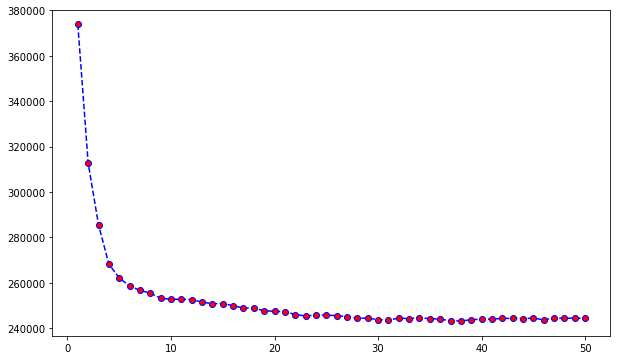

In [41]:
plt.figure(figsize=(10,6))
plt.plot(range(1,51), error_rate, linestyle='--', marker='o', markerfacecolor='red', color='blue')

In [42]:
print("Best K:", error_rate.index(min(error_rate)))
print("Best RMSE:", min(error_rate))

Best K: 37
Best RMSE: 243180.0491744677


<h3> Best RMSE: 243180.0491744677 </h3>

<h2> Running Each Regression Model to get summary of all RMSEs </h2>
<h3> Models tested </h3>
<ul>
    <li> KNN </li>
    <li> Linear Regression </li>
    <li> Ridge </li>
    <li> Elasticnet </li>
    <li> Lasso </li>
    <li> Bayesian Ridge </li>
    <li> Support Vector Regression </li>
    <li> Random Forest Regression </li>
    <li> Decision Tree Regression </li>
</ul>

In [114]:
models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}

atm_names = new_data['ATM Name'].unique()

In [115]:
def compute_rmse_model_list(models, X_train, y_train, X_test, y_test):
    print("RMSEs for each model")
    testing_scores = dict()
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        model_predictions = model.predict(X_test)
        model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
        model_testing_score = model.score(X_test, y_test)
        model_training_score = model.score(X_train, y_train)
        print("For", model_name)
        print("\tTesting RMSE = {}".format(model_rmse))
        print("\tTraining Score =", model_training_score)
        print("\tTesting Score =", model_testing_score)
        
        # Storing the results in a dictionary, so stuff can be easily compared later
        testing_scores[model_name] = dict()
        testing_scores[model_name]['Training Score'] = model_training_score
        testing_scores[model_name]['Testing Score'] = model_testing_score
        testing_scores[model_name]['RMSE'] = model_rmse
    
    return testing_scores

In [119]:
testing_summary['All ATMs Trained with Train Test Split'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 243308.4815900565
	Training Score = 0.45697266653028884
	Testing Score = 0.4469533394817221
For Vanilla Linear Regression
	Testing RMSE = 251419.81922358868
	Training Score = 0.4013361571445507
	Testing Score = 0.409464110262857
For Ridge Linear Regression
	Testing RMSE = 251386.47604234665
	Training Score = 0.4013043683235682
	Testing Score = 0.4096207330748531
For Elasticnet Linear Regression
	Testing RMSE = 299840.48379522713
	Training Score = 0.1599098376804099
	Testing Score = 0.16009954359397116
For Lasso Linear Regression
	Testing RMSE = 251415.86960634057
	Training Score = 0.4013359783757806
	Testing Score = 0.40948266387110405
For Bayesian Ridge Linear Regression
	Testing RMSE = 251396.25827460986
	Training Score = 0.4006642870319033
	Testing Score = 0.40957478518163776
For Support Vector Regression
	Testing RMSE = 330051.3590919249
	Training Score = -0.023764153336445215
	Testing Score = -0.01767786439476282
For Ra

<h3> The scores and RMSEs computed by the above function are stored in the dictionary in the following format </h3>

<h4> After observing the testing and training scores, I think its clear that Decision Tree overfits, but I dont think that was ever that high on our sought after models list, so that's good, other than that everything is not ideal but atleast no overfitting </h4>

<h3> Using only 2017 data as test data and everything else as training data </h3>

In [46]:
numeric_data

,Total amount Withdrawn,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_KK Nagar ATM,ATM Name_Mount Road ATM,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,...,Day_28,Day_29,Day_30,Day_31,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017
0,123800,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,767900,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,503400,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,945300,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11584,468800,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11585,305100,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11586,709900,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11587,408700,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [121]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data['Year_2017'] == 1]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1155


In [122]:
testing_summary['All ATMs Trained with 2017 Test Data'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 370654.38876929344
	Training Score = 0.49334898232826474
	Testing Score = -0.2036759694108361
For Vanilla Linear Regression
	Testing RMSE = 351236.1852653552
	Training Score = 0.4535210215154458
	Testing Score = -0.08086088361456811
For Ridge Linear Regression
	Testing RMSE = 350930.3772714196
	Training Score = 0.4534927053204132
	Testing Score = -0.07897957400080258
For Elasticnet Linear Regression
	Testing RMSE = 343651.78719365434
	Training Score = 0.18540431599596496
	Testing Score = -0.03468585104161148
For Lasso Linear Regression
	Testing RMSE = 351207.1555167714
	Training Score = 0.4535207164047764
	Testing Score = -0.08068222421466187
For Bayesian Ridge Linear Regression
	Testing RMSE = 349989.46216254827
	Training Score = 0.4530724819355578
	Testing Score = -0.07320140697245625
For Support Vector Regression
	Testing RMSE = 339522.5629301751
	Training Score = -0.025059950311879797
	Testing Score = -0.0099702418425564

<h3> Random Forest and Decision Tree overfit here but everything else is trash for both training and testing, idk what can be done about this </h3>

<h3> Finding out the total amount withdrawn per month per year </h3>

In [49]:
new_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
1,Mount Road ATM,767900,SATURDAY,C,H,WHH,1,1,2011
2,Airport ATM,503400,SATURDAY,C,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
4,Christ College ATM,287700,SATURDAY,C,H,WHH,1,1,2011
...,...,...,...,...,...,...,...,...,...
11584,Big Street ATM,468800,FRIDAY,H,H,WHH,9,29,2017
11585,Mount Road ATM,305100,FRIDAY,H,H,WHH,9,29,2017
11586,Airport ATM,709900,FRIDAY,H,H,WHH,9,29,2017
11587,KK Nagar ATM,408700,FRIDAY,H,H,WHH,9,29,2017


In [50]:
# Takes like 15-20 seconds to compute
total_amt_per_mon_per_yr = {}
for year in new_data['Year'].unique():
    for month in new_data['Month'].unique():
        total_amt_per_mon_per_yr[(year, month)] = sum(new_data[new_data.apply(lambda x: x['Year'] == year
                            and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

<p> total_amt_per_mon_per_yr is basically a dictionary whose key is a tuple (year, month) and its value contains the total amount withdrawn in the month of the year specified in the key, so (2011, 1): 65360200, means that 65360200 was withdrawn in total in the month of January 2011 </p>

In [51]:
from pprint import pprint

# Uncomment this if you want to see what the dictionary is like but its a big list and takes up space so I commented it out
# pprint(total_amt_per_mon_per_yr)

In [52]:
total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
print("Total Amount Withdrawn:", total_amount_withdrawn)
print("Average Amount Withdrawn:", avg_amount_withdrawn)

Total Amount Withdrawn: 6053002800
Average Amount Withdrawn: 72059557.14285715


<h3> Figuring out Outlier Months </h3>
<p> So my logic is that I take the total amount withdrawn in each month (of each year ofc) and then check its difference from the average amount withdrawn per month per year, and there's a tolerance percent variable (currently 0.7), so if the difference (positive or negative) is greater than 70% of the avg_amount_withdrawn, then that month of that year is an outlier </p>
<p> I think something similar can be done with days in a month as well </p>

In [53]:
tolerance_percent = 0.7

for key in total_amt_per_mon_per_yr:
    amount = total_amt_per_mon_per_yr[key]
    if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
        print(key)
        # print(total_amt_per_mon_per_yr[key])

(2016, 11)
(2016, 12)
(2017, 10)
(2017, 11)
(2017, 12)


<h3> Removing outlier months from 2017 in test set </h3>

In [124]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data.apply(lambda x: x['Year_2017'] == 1
                            and x['Month_10'] != 1 and x['Month_11'] != 1 and x['Month_12'] != 1, axis=1)]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1053


In [125]:
# testing_summary_all_atms_with_2017_non_outlier_month_data = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)
testing_summary['All ATMs Trained with 2017 Test Data (No Outlier Months)'] = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 372340.49206527043
	Training Score = 0.49334898232826474
	Testing Score = -0.2018997476884299
For Vanilla Linear Regression
	Testing RMSE = 351707.4107674948
	Training Score = 0.4535210215154458
	Testing Score = -0.07238503792997997
For Ridge Linear Regression
	Testing RMSE = 351434.1312815757
	Training Score = 0.4534927053204132
	Testing Score = -0.07071918178027703
For Elasticnet Linear Regression
	Testing RMSE = 345648.1068296639
	Training Score = 0.18540431599596496
	Testing Score = -0.03575269583521212
For Lasso Linear Regression
	Testing RMSE = 351681.79185469187
	Training Score = 0.4535207164047764
	Testing Score = -0.07222881524409619
For Bayesian Ridge Linear Regression
	Testing RMSE = 350577.01082009525
	Training Score = 0.4530724819355578
	Testing Score = -0.06550274948102763
For Support Vector Regression
	Testing RMSE = 341483.98469625093
	Training Score = -0.025059950311879797
	Testing Score = -0.010947000905629

In [126]:
pprint(testing_summary)

{'All ATMs Trained with 2017 Test Data': {'Bayesian Ridge Linear Regression': {'RMSE': 349989.46216254827,
                                                                               'Testing Score': -0.07320140697245625,
                                                                               'Training Score': 0.4530724819355578},
                                          'Decision Tree Regression': {'RMSE': 415090.50076680846,
                                                                       'Testing Score': -0.509582616818163,
                                                                       'Training Score': 1.0},
                                          'Elasticnet Linear Regression': {'RMSE': 343651.78719365434,
                                                                           'Testing Score': -0.03468585104161148,
                                                                           'Training Score': 0.18540431599596496},
                       

<h3> A slight improvement but pretty insignificant sadly </h3>

<h3> Figuring out Outlier Days with 75% difference from the average amount withdrawn per day as the tolerance</h3>

In [56]:
avg_amount_withdrawn_per_day = sum(new_data['Total amount Withdrawn']) / len(new_data['Total amount Withdrawn'])
tolerance_percent = 0.75

outlier_day_data = new_data[new_data.apply(lambda x: abs(avg_amount_withdrawn_per_day - x['Total amount Withdrawn']) > 
                            avg_amount_withdrawn_per_day * tolerance_percent, axis=1)]

In [57]:
outlier_day_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
5,Big Street ATM,52800,SUNDAY,NH,H,HHW,2,1,2011
10,Big Street ATM,88100,MONDAY,NH,W,WWW,3,1,2011
13,KK Nagar ATM,1333100,MONDAY,NH,W,WWW,3,1,2011
...,...,...,...,...,...,...,...,...,...
11558,Christ College ATM,1253100,SATURDAY,NH,H,WHH,9,23,2017
11567,KK Nagar ATM,1175200,MONDAY,NH,W,HWW,9,25,2017
11577,KK Nagar ATM,997800,WEDNESDAY,NH,W,WWW,9,27,2017
11582,KK Nagar ATM,1154900,THURSDAY,NH,W,WWH,9,28,2017


In [58]:
# Kinda useless, prints a really big list that's all
# for idx, row in outlier_day_data.iterrows():
#     print("{}, {}, {}".format(row['Year'], row['Month'], row['Day']))

<p> I used value_counts() on Month, Day and Year of the outlier df but it contains data of multiple ATMs, so I split them to figure out the actual numbers </p>

In [66]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Month'].value_counts(), "\n")

For ATM: Big Street ATM
11    42
3     42
4     40
1     40
7     38
8     34
2     34
6     31
5     27
12    25
10    22
9     20
Name: Month, dtype: int64 

For ATM: KK Nagar ATM
1     95
5     85
8     84
10    83
7     83
11    82
3     82
6     78
4     77
2     76
9     74
12    69
Name: Month, dtype: int64 

For ATM: Christ College ATM
5     38
1     35
4     34
3     33
10    29
8     26
7     26
6     26
2     24
11    16
9     15
12    10
Name: Month, dtype: int64 

For ATM: Airport ATM
1     23
7     22
5     19
3     18
6     17
2     17
11    16
10    16
4     15
9     14
8     14
12    11
Name: Month, dtype: int64 

For ATM: Mount Road ATM
6     40
4     39
5     36
3     36
1     34
8     26
7     25
11    24
10    22
2     20
9     14
12    11
Name: Month, dtype: int64 



<h3> Basically KK Nagar ATM has vastly large number of outlier days as compared to the others and Airport ATM is the best in this regard </h3>

In [60]:
for atm in outlier_day_data['ATM Name'].unique():
    print("For ATM:", atm)
    print(outlier_day_data[outlier_day_data['ATM Name'] == atm]['Year'].value_counts(), "\n")

For Bank: Big Street ATM
2011    243
2012     78
2016     30
2017     24
2014      8
2015      7
2013      5
Name: Year, dtype: int64 

For Bank: KK Nagar ATM
2013    260
2014    258
2012    157
2016     86
2017     85
2015     69
2011     53
Name: Year, dtype: int64 

For Bank: Christ College ATM
2017    92
2014    75
2016    69
2015    34
2013    19
2012    12
2011    11
Name: Year, dtype: int64 

For Bank: Airport ATM
2016    68
2017    54
2015    35
2014    17
2013    14
2012    11
2011     3
Name: Year, dtype: int64 

For Bank: Mount Road ATM
2016    106
2015     54
2014     54
2017     50
2012     30
2013     24
2011      9
Name: Year, dtype: int64 



<h3> For handling outliers, something from the following cell could be used later </h3>

In [61]:
airport_outlier_data = outlier_day_data[outlier_day_data['ATM Name'] == 'Airport ATM'].drop('ATM Name', axis=1)

<h3> Training all models for each ATM separately and the results might shock you! </h3>

In [130]:
def model_training_per_atm(atm_name):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    ''' Finding Outlier Months for each bank separately
    print("\nOutlier Months for bank {} are as follows,".format(bank_name))
    total_amt_per_mon_per_yr = {}
    for year in curr_bank_data['Year'].unique():
       for month in curr_bank_data['Month'].unique():
           total_amt_per_mon_per_yr[(year, month)] = sum(curr_bank_data[curr_bank_data.apply(lambda x: x['Year'] == year
                               and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

    total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
    avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
    # print("Total Amount Withdrawn:", total_amount_withdrawn)
    # print("Average Amount Withdrawn:", avg_amount_withdrawn)

    tolerance_percent = 0.7

    for key in total_amt_per_mon_per_yr:
        amount = total_amt_per_mon_per_yr[key]
        if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
            print(key)
    '''
    
    # This takes 2016 data as test data and ignores 2017 data completely
    # train_data = numeric_curr_bank_data[numeric_curr_bank_data.apply(lambda x: x['Year_2017'] == 0 and 
    #                                                                 x['Year_2016'] == 0, axis=1)]
    # test_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2016'] == 1]
    # Conclusions: For some reason, Airport ATM accuracy increases slightly somehow but everything else gets rekt
    
    
    print("\nFor ATM:", atm_name)
    print("Number of training rows:",len(train_data))
    print("Number of testing rows:", len(test_data))
    print()

    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    testing_dict_curr_atm = compute_rmse_model_list(models, X_train, y_train, X_test, y_test)
    return testing_dict_curr_atm

In [131]:
for atm_name in new_data['ATM Name'].unique():
    testing_dict_curr_atm = model_training_per_atm(atm_name)
    testing_summary[atm_name + ' trained with 2017 Data'] = testing_dict_curr_atm
    
# Note: Bayesian Ridge Linear Regression does not converge for the Mount Road and KK Nagar models and increasing n_iter
# to even 5000 (default is 350) didn't change that at all, so that's sad


For ATM: Big Street ATM
Number of training rows: 2117
Number of testing rows: 237

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 181461.59767223545
	Training Score = 0.28999562819250424
	Testing Score = -0.36556725432459025
For Vanilla Linear Regression
	Testing RMSE = 276512.2844681913
	Training Score = 0.5444464813526175
	Testing Score = -2.1708266083172028
For Ridge Linear Regression
	Testing RMSE = 273587.69620255945
	Training Score = 0.5442115519020725
	Testing Score = -2.104107536431348
For Elasticnet Linear Regression
	Testing RMSE = 160736.02690753856
	Training Score = 0.13017936078590775
	Testing Score = -0.07144551642773656
For Lasso Linear Regression
	Testing RMSE = 276469.1320024553
	Training Score = 0.5444461398934355
	Testing Score = -2.169837008089656
For Bayesian Ridge Linear Regression
	Testing RMSE = 270701.1207086409
	Training Score = 0.5436357614309526
	Testing Score = -2.038951303826138
For Support Vector Regression
	Testing RMSE = 158495.819471549

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318209236896.22656, tolerance: 12393046096.022762
  model = cd_fast.enet_coordinate_descent(


For Support Vector Regression
	Testing RMSE = 322190.0963087881
	Training Score = -0.00016256288294114185
	Testing Score = -2.0085538639651888
For Random Forest Regression
	Testing RMSE = 330544.2287369519
	Training Score = 0.92114860858848
	Testing Score = -2.166595393698463
For Decision Tree Regression
	Testing RMSE = 358425.8769628607
	Training Score = 1.0
	Testing Score = -2.7233351562821104

For ATM: Airport ATM
Number of training rows: 2058
Number of testing rows: 195

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 280998.75391993637
	Training Score = 0.21011877894017894
	Testing Score = -0.320081646974691
For Vanilla Linear Regression
	Testing RMSE = 270419.38396096433
	Training Score = 0.32222981007075846
	Testing Score = -0.2225528522966016
For Ridge Linear Regression
	Testing RMSE = 270340.7285163081
	Training Score = 0.3217569895030462
	Testing Score = -0.22184176086544904
For Elasticnet Linear Regression
	Testing RMSE = 274810.90552300756
	Training Score = 0.

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4886918595366.969, tolerance: 40041415972.54263
  model = cd_fast.enet_coordinate_descent(


 Bayesian Ridge Linear Regression
	Testing RMSE = 449447.70286618423
	Training Score = 0.5109456907699065
	Testing Score = -0.46117843124706037
For Support Vector Regression
	Testing RMSE = 476342.10707451584
	Training Score = -0.010162086368770362
	Testing Score = -0.641280726160238
For Random Forest Regression
	Testing RMSE = 447467.79503584607
	Training Score = 0.9290283152322312
	Testing Score = -0.4483332148724828
For Decision Tree Regression
	Testing RMSE = 483736.2540349255
	Training Score = 1.0
	Testing Score = -0.6926306356122631

For ATM: Christ College ATM
Number of training rows: 2115
Number of testing rows: 240

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 454068.21878890437
	Training Score = 0.2887955781878394
	Testing Score = -0.48406666444966473
For Vanilla Linear Regression
	Testing RMSE = 563369.5987146889
	Training Score = 0.4884805976915243
	Testing Score = -1.2845360365183236
For Ridge Linear Regression
	Testing RMSE = 559635.1538683609
	Training S

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303677188912.1094, tolerance: 13354579722.531445
  model = cd_fast.enet_coordinate_descent(


 Lasso Linear Regression
	Testing RMSE = 563333.8566610938
	Training Score = 0.4884802021606778
	Testing Score = -1.2842461684834077
For Bayesian Ridge Linear Regression
	Testing RMSE = 554222.9690183143
	Training Score = 0.48620201491936166
	Testing Score = -1.2109567113667454
For Support Vector Regression
	Testing RMSE = 464427.1776615809
	Training Score = -0.01517727140145797
	Testing Score = -0.552553057061139
For Random Forest Regression
	Testing RMSE = 570985.7485264153
	Training Score = 0.9142838939241426
	Testing Score = -1.3467224913815858
For Decision Tree Regression
	Testing RMSE = 578297.9511390877
	Training Score = 1.0
	Testing Score = -1.4072129200603452


In [132]:
pprint(testing_summary)

{'Airport ATM trained with 2017 Data': {'Bayesian Ridge Linear Regression': {'RMSE': 270597.6230639246,
                                                                             'Testing Score': -0.2241650040142349,
                                                                             'Training Score': 0.3157519731139333},
                                        'Decision Tree Regression': {'RMSE': 282460.81107805343,
                                                                     'Testing Score': -0.3338543477481968,
                                                                     'Training Score': 1.0},
                                        'Elasticnet Linear Regression': {'RMSE': 274810.90552300756,
                                                                         'Testing Score': -0.26258298215092557,
                                                                         'Training Score': 0.09953188228525989},
                                        'K

<p> I know the output is a bit long, but read it for cool insights and damn Big Street ATM is the OP right now, SVR got 1 lakh 58 thousand RMSE on it </p>

<h3> Upto this point, removing outlier months from test set has had no effect, be it for the model with all ATMs or for individual ATMs, infact it made the RMSE worse at times, so I think we can stop pursuing the outlier month part for now </h3>

<h2> Hyperparameter Tuning </h2>
<p> Right now, just focused on SVR as it performs the best consistently </p>
<p> Note that the function below this cell takes the bank_name and the random search or grid search object and does all the tasks of converting to numeric data, train test split using 2017 data and then does Cross Validation and then computes the RMSE on the best estimator found after hyperparameter search </p>

In [71]:
# Works for both RandomizedSearchCV() object and GridSearchCV() object
def model_training_hyperparam_per_atm(atm_name, param_cv_obj):
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_atm_data = new_data[new_data['ATM Name'] == atm_name].drop('ATM Name', axis=1)
    numeric_curr_atm_data = convert_categorical_to_numerical(curr_atm_data, categorical_features_list)
    
    train_data = numeric_curr_atm_data[numeric_curr_bank_data['Year_2017'] == 0]
    test_data = numeric_curr_atm_data[numeric_curr_atm_data['Year_2017'] == 1]
    
    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    param_cv_obj.fit(X_train, y_train)
    print("Best Parameters:\n", param_cv_obj.best_params_)
    print("\nBest Score:", param_cv_obj.best_score_)
    
    best_model = param_cv_obj.best_estimator_
    model_predictions = best_model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print("Test RMSE:", model_rmse)

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

random_grid_svr = {'C': list(np.logspace(np.log10(0.001), np.log10(1000), num=50)),
                         'epsilon': list(np.logspace(np.log10(0.001), np.log10(1000), num=50))}

random_cv_svr = RandomizedSearchCV(SVR(), random_grid_svr, n_iter=50, verbose=5, n_jobs=-1)
grid_cv_svr = GridSearchCV(SVR(), random_grid_svr, verbose=5, n_jobs=-1)

<h3> SVR Randomized Search for all ATMs individually </h3>

In [77]:
for atm_name in atm_names:
    print("\nPerforming Random Search with SVR on", atm_name, "\n")
    model_training_hyperparam_per_bank(atm_name, random_cv_svr)


Performing Random Search with SVR on Big Street ATM 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   34.9s finished


Best Parameters:
 {'epsilon': 0.09102981779915217, 'C': 1000.0}

Best Score: -3.7124562844354996
Test RMSE: 158667.22328326612

Performing Random Search with SVR on Mount Road ATM 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.3s finished


Best Parameters:
 {'epsilon': 8.286427728546842, 'C': 754.3120063354608}

Best Score: -0.17360611533618792
Test RMSE: 321900.5095177688

Performing Random Search with SVR on Airport ATM 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   29.9s finished


Best Parameters:
 {'epsilon': 44.98432668969444, 'C': 754.3120063354608}

Best Score: -0.3636847590282068
Test RMSE: 275640.7992790201

Performing Random Search with SVR on KK Nagar ATM 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.3s finished


Best Parameters:
 {'epsilon': 0.004094915062380427, 'C': 1000.0}

Best Score: -0.5388856431758656
Test RMSE: 478463.1040340031

Performing Random Search with SVR on Christ College ATM 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   31.7s finished


Best Parameters:
 {'epsilon': 79.06043210907701, 'C': 754.3120063354608}

Best Score: -0.8125141511904909
Test RMSE: 460281.29039404966


<h3> Training Model on All ATMs but using Test Data from individual ATMs </h3>

In [88]:
def all_atm_model_training_with_different_test_atms():
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    atm_names = new_data['ATM Name'].unique()
    
    numeric_data = convert_categorical_to_numerical(new_data, categorical_features_list)
    
    train_data = numeric_data[numeric_data['Year_2017'] == 0]
    test_data = numeric_data[numeric_data['Year_2017'] == 1]
    
    for atm_name in atm_names:
        print("\nFor ATM:", atm_name)
    
        train_data = numeric_data[numeric_data['Year_2017'] == 0]
        test_data = numeric_data[numeric_data['Year_2017'] == 1]
        
        X_train = train_data.drop('Total amount Withdrawn', axis=1)
        y_train = train_data['Total amount Withdrawn']
        
        # I know this is sad jugaad, but its honest work and yeah Airport ATM column gets dropped in pd.get_dummies
        # so I'm just using that knowledge to hardcode column names here
        if atm_name != 'Airport ATM':
            curr_atm_test_data = test_data[test_data['ATM Name_' + atm_name] == 1]
        else:
            curr_atm_test_data = test_data[test_data.apply(
                lambda x: x['ATM Name_Big Street ATM'] == 0 and x['ATM Name_Mount Road ATM'] == 0
                        and x['ATM Name_KK Nagar ATM'] == 0 and x['ATM Name_Christ College ATM'] == 0, axis=1)]
        
        X_test = curr_atm_test_data.drop('Total amount Withdrawn', axis=1)
        y_test = curr_atm_test_data['Total amount Withdrawn']

        compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

<h4> Tbh idk what to make of this result, its weird. In some ways, the trash ATMs are performing trash but some models are performing quite well on Mount Road ATM which didn't happen with the individual model, so I guess KK and Christ College are the ones that we need to destroy </h4>

In [89]:
all_atm_model_training_with_different_test_atms()


For ATM: Big Street ATM
RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 162048.53448888898
	Training Score = 0.49334898232826474
	Testing Score = -0.08901496813590071
For Vanilla Linear Regression
	Testing RMSE = 220189.09903158885
	Training Score = 0.4535210215154458
	Testing Score = -1.0106443707888442
For Ridge Linear Regression
	Testing RMSE = 219576.6116433178
	Training Score = 0.4534927053204132
	Testing Score = -0.999474139962197
For Elasticnet Linear Regression
	Testing RMSE = 195328.06172366143
	Training Score = 0.18540431599596496
	Testing Score = -0.5822420217548594
For Lasso Linear Regression
	Testing RMSE = 220144.91294633946
	Training Score = 0.4535207164047764
	Testing Score = -1.009837486253661
For Bayesian Ridge Linear Regression
	Testing RMSE = 217227.5114218556
	Training Score = 0.4530724819355578
	Testing Score = -0.9569209709453393
For Support Vector Regression
	Testing RMSE = 206787.19561842582
	Training Score = -0.025059950311879797
	Testing Score 

<h3> Storing Testing Summary of all Training before the Hyperparameter Stuff into a JSON file </h3>

In [134]:
# import json
# with open('testing_summary.json', 'w') as file:
#     json_string = json.dumps(testing_summary, default=lambda o: o.__dict__, indent=4)
#     file.write(json_string)
    